In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import numpy as np

import matplotlib.pyplot as plt
import random
import glob

from PIL import Image
from IPython.display import clear_output
from IPython.display import Image as IpyImage
import imageio
import cv2

from tqdm import tqdm

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Invalid device or cannot modify virtual devices once initialized.")
    pass

In [5]:
BATCH_SIZE=2
LATENT_DIM=256
IMG_SIZE=256

## Utilities

In [6]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

## Download and Prepare the Dataset

You will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset for this exercise. As before, you will only need to create batches of the training images. The preprocessing steps are also shown below.

In [7]:
def get_dataset_images_paths(image_dir):
    '''Retorna lista de caminhos para arquivos em image_dir'''

    image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))
    
    return image_paths

# fnames = get_dataset_images_paths('./data/train/positivo')

def map_image(img_fname):
    '''preprocessa imagens em img_fname'''
    
    img_raw = tf.io.read_file(img_fname)
    image = tf.image.decode_jpeg(img_raw)
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = RGB2HSD(image)
    image = tf.reshape(image, shape=(IMG_SIZE, IMG_SIZE, 3,))
    
    return image

def map_hsd(img_fname):
    image = cv2.cvtColor(cv2.imread(img_fname), cv2.COLOR_BGR2RGB)
    image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    image = RGB2HSD(image)
    
    return tf.cast(image, tf.float32)




In [8]:
def RGB2HSD(X):
    eps = np.finfo(float).eps
    X[np.where(X==0.0)] = eps
    
    OD = -np.log(X / 1.0)
    D  = np.mean(OD,2)
    D[np.where(D==0.0)] = eps
    
    cx = OD[:,:,0] / (D) - 1.0
    cy = (OD[:,:,1]-OD[:,:,2]) / (np.sqrt(3.0)*D)
    
    D = np.expand_dims(D,2)
    cx = np.expand_dims(cx,2)
    cy = np.expand_dims(cy,2)
            
    X_HSD = np.concatenate((D,cx,cy),2)
    return X_HSD
    
def HSD2RGB(X_HSD):
    
    X_HSD_0, X_HSD_1, X_HSD_2  = tf.split(X_HSD, [1,1,1], axis=3)
    D_R = (X_HSD_1+1) * X_HSD_0
    D_G = 0.5*X_HSD_0*(2-X_HSD_1 + tf.sqrt(tf.constant(3.0))*X_HSD_2)
    D_B = 0.5*X_HSD_0*(2-X_HSD_1 - tf.sqrt(tf.constant(3.0))*X_HSD_2)
    
    X_OD = tf.concat([D_R,D_G,D_B],3)
    X_RGB = 1.0 * tf.exp(-X_OD)
    return X_RGB   
    
def HSD2RGB_Numpy(X_HSD):
    
    X_HSD_0 = X_HSD[...,0]
    X_HSD_1 = X_HSD[...,1]
    X_HSD_2 = X_HSD[...,2]
    D_R = np.expand_dims(np.multiply(X_HSD_1+1 , X_HSD_0), 2)
    D_G = np.expand_dims(np.multiply(0.5*X_HSD_0, 2-X_HSD_1 + np.sqrt(3.0)*X_HSD_2), 2)
    D_B = np.expand_dims(np.multiply(0.5*X_HSD_0, 2-X_HSD_1 - np.sqrt(3.0)*X_HSD_2), 2)
     
    X_OD = np.concatenate((D_R,D_G,D_B), axis=2)
    X_RGB = 1.0 * np.exp(-X_OD)
    return X_RGB         

In [9]:
paths = get_dataset_images_paths('./data/template')

# randomiza a array de nomes de arquivo
random.shuffle(paths)

# pega o tamanho da lista de nomes de arquivos
# pega 80% dos nomes na lista para treinamento e 20% para validação
paths_len = len(paths)
train_paths_len = int(paths_len * 1.0)

train_paths = paths[:train_paths_len]

X = []

for fname in train_paths:
    X.append(map_hsd(fname))

# configura o datasete de treinamento
training_ds = tf.data.Dataset.from_tensor_slices((X))
# training_ds = training_ds.map(map_hsd)
# training_ds = training_ds.batch(BATCH_SIZE)

print(f'number of images in the training set: {len(X)}')



number of images in the training set: 7


In [10]:
for image in training_ds:
    print(image.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [11]:
#plot_results(next(training_ds.as_numpy_iterator()), 4)

In [12]:
# tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
# tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
# tf.config.experimental_connect_to_cluster(tpu_cluster_resolver) 
# tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)   
# strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver)  

In [62]:
# Utilities

def _get_norm_layer(norm):
    if norm == 'NA':
        return lambda: lambda x: x
    elif norm == 'batch_normalization':
        return layers.BatchNormalization
    elif norm == 'instance_normalization':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_normalization':
        return layers.LayerNormalization


def get_initializers():
    return (tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=3), # conv initializer
            tf.keras.initializers.RandomNormal(mean=1.0, stddev=0.02, seed=3)) # bn gamma initializer


def gradient_penalty(f, real, fake, mode):
    def _gradient_penalty(f, real, fake=None):
        def _interpolate(a, b=None):
            if b is None:   # interpolation in DRAGAN
                beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter

        x = _interpolate(real, fake)
        with tf.GradientTape() as t:
            t.watch(x)
            pred = f(x)
        grad = t.gradient(pred, x)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)

        return gp

    if mode == 'none':
        gp = tf.constant(0, dtype=real.dtype)
    elif mode == 'dragan':
        gp = _gradient_penalty(f, real)
    elif mode == 'wgan-gp':
        gp = _gradient_penalty(f, real, fake)

    return gp

In [63]:
def create_generator(input_shape=(IMG_SIZE, IMG_SIZE, 1),
                    output_channels=3,
                    dim=64,
                    n_upsamplings=4,
                    norm='batch_normalization',
                    name='generator'):
  
    Normalization = _get_norm_layer(norm)
    conv_initializer, bn_gamma_initializer = get_initializers()
    
    # Definir o INPUT = espaço latente = canal D da imagem
    x = inputs = tf.keras.Input(shape=input_shape)
    
    # definir o Encoder / downsampling
    
    x = layers.Conv2D(16, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.Conv2D(32, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.MaxPool2D(2, 2)(x)
    x = layers.Conv2D(64, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.MaxPool2D(2, 2)(x)
    x = layers.Conv2D(128, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    
    # decoder / upsampling

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(256, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.Conv2D(32, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.Conv2D(3, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [64]:
g = create_generator()
g.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 conv2d_40 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                    

In [65]:
def create_d_q_net(input_shape=(IMG_SIZE, IMG_SIZE, 1),
                        dim=64,
                        n_downsamplings=4,
                        norm='batch_normalization',
                        name='q_net'):
    Normalization = _get_norm_layer(norm)
    conv_initializer, bn_gamma_initializer = get_initializers()

    x = inputs = tf.keras.Input(shape=input_shape)
    
    
    
    x = layers.Conv2D(32, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.Conv2D(32, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.MaxPool2D(2, 2)(x)
    
    x = layers.Conv2D(32, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.MaxPool2D(2, 2)(x)
    
    x = layers.Conv2D(16, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.MaxPool2D(2, 2)(x)
    
    x = layers.Conv2D(16, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    x = layers.MaxPool2D(2, 2)(x)
    
    x = layers.Conv2D(8, 3,  padding='same', activation='relu', kernel_initializer=conv_initializer)(x)
    d_out = layers.GlobalAveragePooling2D()(x)
    d_out = layers.Dense(1, activation='sigmoid')(d_out)
    
    x = layers.MaxPool2D(2, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32)(x)
    
    x1 = layers.Dense(8)(x)
    x2 = layers.Dense(8)(x)
    x3 = layers.Dense(8)(x)
    
    r = layers.Dense(4, activation='softmax')(x1)
    g = layers.Dense(4, activation='softmax')(x2)
    b = layers.Dense(4, activation='softmax')(x3)
    
    q_out = tf.stack([r,g,b], axis=-1)
    
    d_net = tf.keras.Model(inputs=inputs, outputs=d_out, name='d_net') 
    q_net = tf.keras.Model(inputs=inputs, outputs=q_out, name='q_net')
    return (d_net, q_net)

In [66]:
# d_model, q_model = create_d_q_net()
# d_model.summary()
r = np.random.dirichlet((1,9),4) 
print(r)
noise = np.arange(1,13).reshape((3,4))
mixture = np.arange(1,13).reshape((4,3))
print(mixture)
print()
print(noise)
print()
C = np.dot(noise,mixture)
print(C)
print()
print(np.argmax(r, axis=0))

[[0.03068061 0.96931939]
 [0.2063874  0.7936126 ]
 [0.14490987 0.85509013]
 [0.21788207 0.78211793]]
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]

[[ 70  80  90]
 [158 184 210]
 [246 288 330]]

[3 0]


In [67]:
# Settings
batch_size = 8
resize = 128
shape = (resize, resize, 3)
z_dim = 512
n_G_upsamplings = n_D_downsamplings = 5
gradient_penalty_mode = 'none'
out_dir = './data/tmp'

if gradient_penalty_mode == 'none':
    d_norm = 'batch_normalization'
elif gradient_penalty_mode in ['dragan', 'wgan-gp']:
    # Avoid using BN with GP
    d_norm = 'layer_normalization'

gradient_penalty_weight = 10.0


# Build the GAN
#with strategy.scope():
# create the generator model
model_G = create_generator(input_shape=(256, 256, 1))

# create the discriminator model
model_D, _ = create_d_q_net()

# print summaries
model_G.summary()
model_D.summary()

# set optimizers
param_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
param_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# create distributed dataset
#dataset = strategy.experimental_distribute_dataset(dataset)

# set the loss function
loss_func = tf.keras.losses.BinaryCrossentropy(
    from_logits=False
)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 conv2d_49 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                    

In [68]:
# Utilities

def make_grid(imgs, nrow, padding=0):
    assert imgs.ndim == 4 and nrow > 0

    batch, height, width, ch = imgs.shape
    n = nrow * (batch // nrow + np.sign(batch % nrow))
    ncol = n // nrow
    pad = np.zeros((n - batch, height, width, ch), imgs.dtype)
    x = np.concatenate([imgs, pad], axis=0)

    # border padding if required
    if padding > 0:
        x = np.pad(x, ((0, 0), (0, padding), (0, padding), (0, 0)),
                   "constant", constant_values=(0, 0))
        height += padding
        width += padding

    x = x.reshape(ncol, nrow, height, width, ch)
    x = x.transpose([0, 2, 1, 3, 4])  # (ncol, height, nrow, width, ch)
    x = x.reshape(height * ncol, width * nrow, ch)
    
    if padding > 0:
        x = x[:(height * ncol - padding),:(width * nrow - padding),:]
    return x

def save_img(imgs, filepath, nrow, padding=0):
    grid_img = make_grid(imgs, nrow, padding=padding)
    grid_img = ((grid_img + 1.0) * 127.5).astype(np.uint8)
    with Image.fromarray(grid_img) as img:
        img.save(filepath)

In [69]:
def train_on_batch(real_img):
#def train_on_batch(real_img1, real_img2):
    '''trains the GAN on a given batch'''
    # concatenate the real image inputs
    #real_img = tf.concat([real_img1, real_img2], axis=0)

    # PHASE ONE - train the discriminator
    with tf.GradientTape() as d_tape:

        # create noise input
        z = tf.random.normal(shape=(real_img.shape[0],1, 1, z_dim))
        real_img = real_img[...,0]
        D = tf.reshape(real_img, [1, 256, 256, 1])
        real_img = tf.expand_dims(real_img, axis=0)
        
        # generate fake images
        fake_img = model_G(D)

        # feed the fake images to the discriminator
        fake_out = model_D(fake_img)

        # feed the real images to the discriminator
        real_out = model_D(real_img)

        # use the loss function to measure how well the discriminator
        # labels fake or real images
        d_fake_loss = loss_func(tf.zeros_like(fake_out), fake_out)
        d_real_loss = loss_func(tf.ones_like(real_out), real_out)

        # get the total loss
        d_loss = (d_fake_loss + d_real_loss) 
        d_loss = tf.reduce_sum(d_loss) / (batch_size * 2)

        # Gradient Penalty (ignore if you set mode to `none`)
        gp = gradient_penalty(model_D, real_img, fake_img, mode=gradient_penalty_mode)
        gp = gp  / (batch_size * 2)
        d_loss = d_loss + gp * gradient_penalty_weight

    # get the gradients
    gradients = d_tape.gradient(d_loss, model_D.trainable_variables)
    
    # update the weights of the discriminator
    param_D.apply_gradients(zip(gradients, model_D.trainable_variables))
    

    # PHASE TWO - train the generator
    with tf.GradientTape() as g_tape:
        # create noise input
        z = tf.random.normal(shape=(real_img.shape[0], 1, 1, z_dim))
        
        # generate fake images
        fake_img = model_G(D)

        # feed fake images to the discriminator
        fake_out = model_D(fake_img)
        
        # use loss function to measure how well the generator
        # is able to trick the discriminator (i.e. model_D should output 1's)
        g_loss = loss_func(tf.ones_like(fake_out), fake_out)
        g_loss = tf.reduce_sum(g_loss) / (batch_size * 2)
    
    # get the gradients
    gradients = g_tape.gradient(g_loss, model_G.trainable_variables)

    # update the weights of the generator
    param_G.apply_gradients(zip(gradients, model_G.trainable_variables))
    
    # return the losses and fake images for monitoring
    return d_loss, g_loss, fake_img 

In [70]:
# generate a batch of noisy input
test_z = tf.random.normal(shape=(256, 256, 1))

# start loop
for epoch in range(100): 
    with tqdm(training_ds) as pbar:
        pbar.set_description(f"[Epoch {epoch}]")
        for step, X in enumerate(pbar):
            # train on the current batch
            d_loss, g_loss, fake = train_on_batch(X)

            # display the losses
            pbar.set_postfix({"g_loss": g_loss.numpy(), "d_loss": d_loss.numpy()})
    
        # generate fake images
        #fake_img = model_G(test_z)

    # save output
    # if not os.path.exists(out_dir):
    #     os.makedirs(out_dir)
    # file_path = out_dir+f"/epoch_{epoch:04}.png"
    # if epoch % 100 == 0:
    #     save_img(fake_img.numpy()[:64], file_path, 8)
    
    # display gallery of fake faces
    # if epoch % 1 == 0:
    #     with Image.open(file_path) as img:
    #         plt.imshow(np.asarray(img))
    #         plt.show()

[Epoch 99]: 100%|██████████| 7/7 [00:00<00:00, 10.53it/s, g_loss=0.516, d_loss=1.58e-5]


In [79]:
for img in training_ds.take(1):
    print(img.shape)                     
    D = img[...,0]
    print(D.shape)
    
D = tf.reshape(D, [1, 256, 256, 1])

(256, 256, 3)
(256, 256)


In [81]:
img = model_G(D)

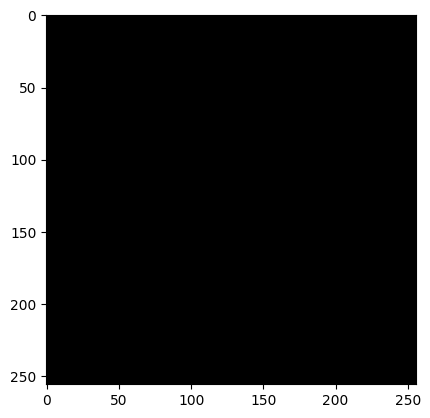

In [92]:
img = tf.reshape(img,[256,256,1])
img = tf.cast(img*255, tf.uint8)
plt.imshow(img, cmap='gray')